In [1]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import cv2

import torch
from torchvision import transforms

import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import operator

sys.path.append('../')
from torchlib.neuralnet import  NeuralNet
from torchlib.datasets import ferptransform
from torchlib.datasets  import  imageutl as imutl
from torchlib import netmodels



import matplotlib.pyplot as plt
plt.ion()   # interactive mode

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


In [2]:


STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]


def imageshow( image ):
    plt.figure( figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.ioff()
    plt.show()


# x,y,w,h -> x1,y1,x2,y2 
def tobbox(box):
    return np.array( [box[0], box[1], box[2]+box[0], box[3]+box[1] ] )

def drawface(image, bbox ):    
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2],bbox[3]), color=[10,10,128], thickness=3)
    return image    

def roi( image, box ):
    imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    roi_gray = imgray[box[1]:box[3], box[0]:box[2]]
    return roi_gray


def dictbox2arraybox(box):
    bbox = np.array([box['top'],box['left'],box['top']+box['width'],box['left']+box['height']])
    return bbox


def draw_bounding_box(image, bbox, label, color='red', thickness=4):
    
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB') 
    im_width, im_height = image_pil.size

    draw = ImageDraw.Draw(image_pil)
    #xmin = bbox[0,0]; ymin = bbox[0,1];
    #xmax = bbox[1,0]; ymax = bbox[1,1];
    #(left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    (left, top, right, bottom ) = bbox

    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    
    try:
        font = ImageFont.truetype('/usr/share/fonts/freefont/FreeSans.ttf', 32, encoding="unic") #'arial.ttf'
        #font = ImageFont.truetype('arial.ttf', 32) 
    except IOError:
        font = ImageFont.load_default()
    
    text_bottom = top
    
    # Reverse list and print from bottom to top.
    #for display_str in display_str_list[::-1]:
    
    emtname=label[0]
    emtscore=label[1]
    display_str = '{}:{:.2f}% '.format( emtname, emtscore*100 );
    
    text_width, text_height = font.getsize( display_str )
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), 
        (left + text_width, text_bottom)],
        fill=color)
    
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin
    
    np.copyto(image, np.array(image_pil))



def load(net, pathnamemodel):
    bload = False
    if pathnamemodel:
        if os.path.isfile(pathnamemodel):
            print("=> loading checkpoint '{}'".format(pathnamemodel))
            checkpoint = torch.load( pathnamemodel, map_location=lambda storage, loc: storage )

            #net._create_model(checkpoint['arch'], checkpoint['num_classes'], 3, False )    
            net.net = netmodels.premodels.InceptionV3( checkpoint['num_classes'],  1 )
            net.size_input = 299
            net.s_arch = checkpoint['arch']
            net.num_output_channels = 1
            net.num_input_channels = checkpoint['num_classes']            
            net.net.load_state_dict( checkpoint['state_dict'] )               

            print("=> loaded checkpoint for {} arch!".format(checkpoint['arch']))
            bload = True
        else:
            print("=> no checkpoint found at '{}'".format(pathnamemodel))        
    return bload


In [3]:
project='../../out/netruns'
name='nettest'
pathmodel='../../out/netruns/exp_net_inceptionv3_lr0001pl_daum_proc_001/model_best.pth.tar'
no_cuda=True
gpu=0

In [4]:
# create net

emotion_name = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']
network = NeuralNet(
        patchproject=project,
        nameproject=name,
        no_cuda=no_cuda,
        gpu=gpu
        )

# load model
load( network, pathmodel )

=> loading checkpoint '../../out/netruns/exp_net_inceptionv3_lr0001pl_daum_proc_001/model_best.pth.tar'
fc.weight dim model torch.Size([8, 2048]) vs dim checkpointtorch.Size([1000, 2048])
fc.bias dim model torch.Size([8]) vs dim checkpointtorch.Size([1000])
=> loaded checkpoint for inceptionv3 arch!


True

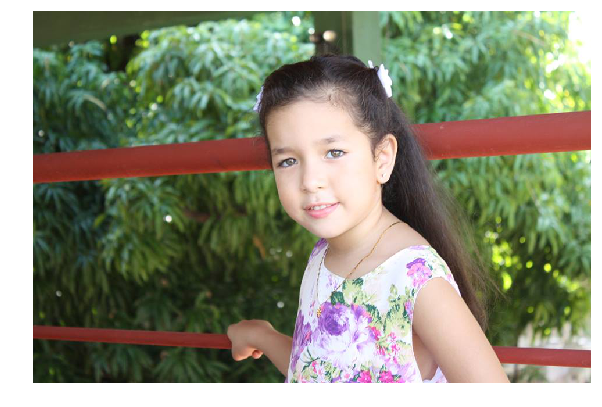

In [5]:

pathnameimage = '../../db/demo/img006.jpeg'
image = cv2.imread(pathnameimage)[:,:,(2,1,0)]
imageshow(image)


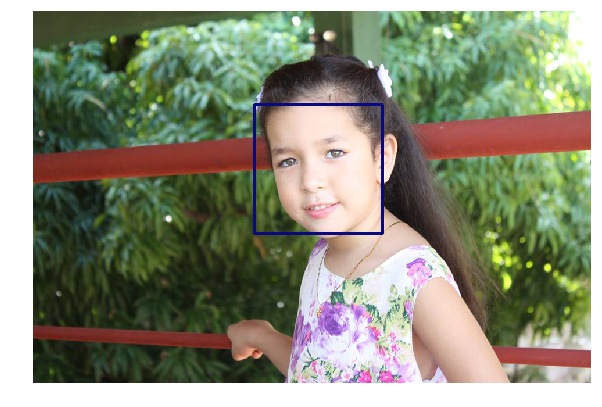

In [58]:
#x,y,w,h
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(imgray, 1.3, 5)

image_sh = image.copy()
for box in faces:
    drawface( image_sh, tobbox(box) )
imageshow( image_sh )


face:  0
----------------------------
surprise 0.0000
sadness 0.0000
neutral 0.0002
happiness 99.9998
anger 0.0000
fear 0.0000
contempt 0.0000
disgust 0.0000


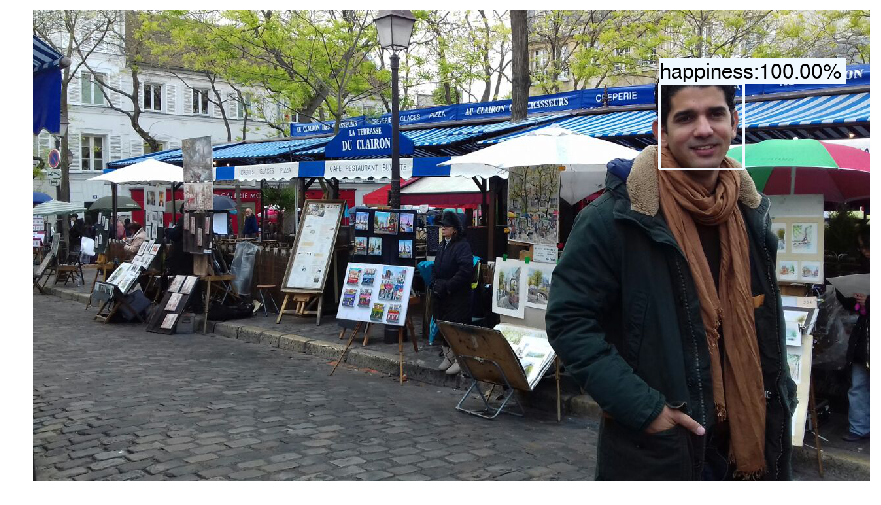

In [60]:
tofer = ferptransform.FERImageDistort( width=network.size_input, height=network.size_input, determinisitc=True, preproc=True)
totensor = transforms.ToTensor()


pathnameimage = '../../db/demo/img001.jpg'
image = cv2.imread(pathnameimage)[:,:,(2,1,0)]

#x,y,w,h
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# face detection
imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(imgray, 1.3, 5)

# emotion recognition
image_sh = image.copy()
for k, box in enumerate(faces):
    
    bbox = tobbox(box)
    imface = roi(image, bbox)
    imface = tofer(imface)
    imfacetensor = torch.from_numpy(imface[:,:,np.newaxis, np.newaxis].transpose((2, 3, 0, 1))).float()
    imfacetensor = torch.cat((imfacetensor, imfacetensor, imfacetensor), dim=1)
    
    # predict 
    y = network.inference(imfacetensor)[0]
    score = dict(zip(emotion_name, y))
    labelhat = np.argmax(y)
    curremot = max(score.items(), key=operator.itemgetter(1)) 
    
    print('face: ', k)
    print('----------------------------')
    for e,v in score.items():
        print(e, '{:.4f}'.format(v*100) )
    
    # draw result
    draw_bounding_box(image_sh, bbox, curremot, color=STANDARD_COLORS[k])
    #drawface( image_sh, bbox )
    
#     plt.imshow(imface, cmap='gray')
#     plt.title( emotion_name[labelhat] )
#     plt.show()


plt.figure( figsize=(15,20) )
plt.imshow(image_sh)
plt.axis('off')
plt.ioff()
plt.show()

In [54]:

class cDetectionNet(object):
    
    def __init__(self, net):
        self.network = net
    
    def create(self):
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        self.tofer = ferptransform.FERImageDistort( 
            width=self.network.size_input, 
            height=self.network.size_input, 
            determinisitc=True, 
            preproc=True)
        self.totensor = transforms.ToTensor()
        
        
    def process(self, frame):
        
        # predict face
        imgray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = self.face_cascade.detectMultiScale(imgray, 1.3, 5)
        
        # emotion recognition
        image_sh = frame.copy()
        for k, box in enumerate(faces):
            
            bbox = tobbox(box)
            imface = roi(image, bbox)
            imface = self.tofer(imface)
            imfacetensor = torch.from_numpy(imface[:,:,np.newaxis, np.newaxis].transpose((2, 3, 0, 1))).float()
            imfacetensor = torch.cat((imfacetensor, imfacetensor, imfacetensor), dim=1)

            # predict emotion
            y = self.network.inference(imfacetensor)[0]
            score = dict(zip(emotion_name, y))
            labelhat = np.argmax(y)
            curremot = max(score.items(), key=operator.itemgetter(1)) 
            
            print('face: ', k)
            print('----------------------------')
            for e,v in score.items():
                print(e, '{:.4f}'.format(v*100) )

            # draw result
            draw_bounding_box(image_sh, bbox, curremot, color=STANDARD_COLORS[k], thickness=4)
        
        return image_sh
    



(288, 360, 3) 0 255


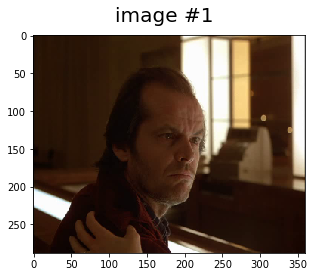

(288, 360, 3) 0 255


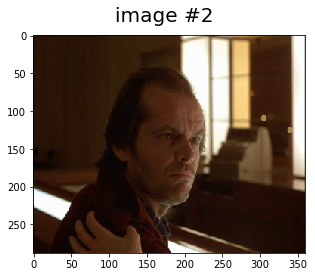

(288, 360, 3) 0 255


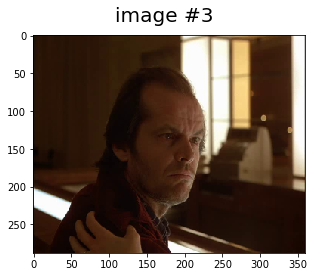

(288, 360, 3) 0 255


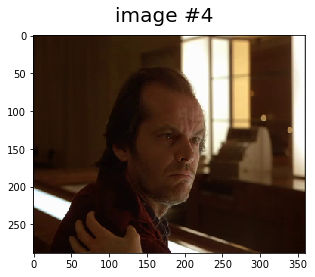

In [60]:


import pylab
import imageio

#filename = '../../db/video/tmp.mp4'
#cap = cv2.VideoCapture( filename )
#print(cap.isOpened())

#iter = 0;
#for every frame
#while(cap.isOpened()):
#     ret, frame = cap.read();    
#     iter+=1;
#     frame = frame[:,:,(2,1,0)]
#     print(frame.shape)    
#     break;


detector = cDetectionNet(network)
detector.create()

filename = '../../db/video/005138840.avi'
vid = imageio.get_reader(filename,  'ffmpeg')
nums = [1, 2, 3, 4]
for num in nums:
    
    image = vid.get_data(num)
    image = cv2.resize(image, None, fx=0.5, fy=0.5 )
    print(image.shape, image.min(), image.max() )
    
    image = detector.process( image )

    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)
    pylab.show()


   
    
    
    
